In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from collections import Counter
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import lightgbm as lgb

In [2]:
def get_categorical_var(df):
    return [col for col in df.columns if df[col].dtype == 'object']

def imputer(data):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    data = imp.fit_transform(data)
    data = data.reshape(len(data), )
    return data 

def to_dummies(df):
    category = get_categorical_var(df)
    for var in category:
        dummy = pd.get_dummies(df[var], columns=var, dummy_na=True)
        for col in dummy.columns:
            if col == np.nan:
                dummy[var+'_NONE'] = dummy[np.nan]
            else:
                dummy[var+'_' + str(col)] = dummy[col]
            dummy = dummy.drop(columns=[col])
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(columns=[var])
    return df

** Load Data **

In [3]:
train_data = pd.read_csv('application_train.csv')
test_data = pd.read_csv('application_test.csv')

- Load application (selected 30 features from original table) and previous application (selected 20 features from original table) data

In [4]:
X_train = pd.read_csv('app_train_prev.csv')
X_test = pd.read_csv('app_test_prev.csv')
y_train = train_data['TARGET']

In [5]:
payment_data = pd.read_csv('installments_payments.csv')
credit_data = pd.read_csv('credit_card_balance.csv')
cash_data = pd.read_csv('POS_CASH_balance.csv')
bureau_data = pd.read_csv('bureau.csv')
bureau = pd.read_csv('bureau_balance.csv')

- Merge bureau data

In [6]:
bureau_data = to_dummies(bureau_data)
bureau = to_dummies(bureau)
bureau_data = bureau_data.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
bureau = bureau.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
bureau_data = bureau_data.merge(bureau, how='left', on='SK_ID_BUREAU')
bureau_data = bureau_data.groupby('SK_ID_CURR').agg('mean')

for col in bureau_data.columns:
        if col != 'SK_ID_CURR' or col != 'SK_ID_BUREAU':
            bureau_data[col] = imputer(np.array(bureau_data[col]).reshape(-1, 1))


for col in bureau.columns:
        if col != 'SK_ID_CURR' or col != 'SK_ID_BUREAU':
            bureau[col] = imputer(np.array(bureau[col]).reshape(-1, 1))

X_train = X_train.merge(bureau_data, how='left', on='SK_ID_CURR')
X_test = X_test.merge(bureau_data, how='left', on='SK_ID_CURR')

X_train = X_train.groupby('SK_ID_CURR').agg('mean')
X_test = X_test.groupby('SK_ID_CURR').agg('mean')

- Load installment payment data

In [7]:
payment_data = pd.DataFrame(payment_data.loc[:, payment_data.columns != 'SK_ID_PREV'])

payment_data = to_dummies(payment_data)
for col in payment_data.columns:
        if col != 'SK_ID_CURR':
            payment_data[col] = imputer(np.array(payment_data[col]).reshape(-1, 1))

payment_data = payment_data.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.merge(payment_data, how='left', on='SK_ID_CURR')
X_test = X_test.merge(payment_data, how='left', on='SK_ID_CURR')

X_train = X_train.groupby('SK_ID_CURR').agg('mean')
X_test = X_test.groupby('SK_ID_CURR').agg('mean')

- Load credit card balance data

In [8]:
credit_data = pd.DataFrame(credit_data.loc[:, credit_data.columns != 'SK_ID_PREV'])

credit_data = to_dummies(credit_data)
for col in credit_data.columns:
        if col != 'SK_ID_CURR':
            credit_data[col] = imputer(np.array(credit_data[col]).reshape(-1, 1))

credit_data = credit_data.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.merge(credit_data, how='left', on='SK_ID_CURR')
X_test = X_test.merge(credit_data, how='left', on='SK_ID_CURR')

X_train = X_train.groupby('SK_ID_CURR').agg('mean')
X_test = X_test.groupby('SK_ID_CURR').agg('mean')

- Load cash data

In [9]:
cash_data = pd.DataFrame(cash_data.loc[:, cash_data.columns != 'SK_ID_PREV'])

cash_data = to_dummies(cash_data)
for col in cash_data.columns:
        if col != 'SK_ID_CURR':
            cash_data[col] = imputer(np.array(cash_data[col]).reshape(-1, 1))
            
cash_data = cash_data.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.merge(cash_data, how='left', on='SK_ID_CURR')
X_test = X_test.merge(cash_data, how='left', on='SK_ID_CURR')

X_train = X_train.groupby('SK_ID_CURR').agg('mean')
X_test = X_test.groupby('SK_ID_CURR').agg('mean')

** Data Preprocessing **

In [10]:
def data_processing(X_train, X_test):
    X_train = to_dummies(X_train)
    X_test = to_dummies(X_test)

    if len(list(X_test.columns)) > len(list(X_train.columns)):
        complement = list(set(X_test.columns) - set(X_train.columns))
        for c in complement:
            index = list(X_test.columns).index(c)
            X_train.insert(loc=index, column=c, value=np.zeros(len(X_train)))
        
    elif len(list(X_test.columns)) < len(list(X_train.columns)):
        complement = list(set(X_train.columns) - set(X_test.columns))
        for c in complement:
            index = list(X_train.columns).index(c)
            X_test.insert(loc=index, column=c, value=np.zeros(len(X_test)))
        

    for col in X_train.columns:
        if col != 'SK_ID_CURR':
            X_train[col] = imputer(np.array(X_train[col]).reshape(-1, 1))

    for col in X_test.columns:
        if col != 'SK_ID_CURR':
            X_test[col] = imputer(np.array(X_test[col]).reshape(-1, 1))

    X_train = X_train.groupby('SK_ID_CURR').agg('mean')
    X_test = X_test.groupby('SK_ID_CURR').agg('mean')

    return X_train, X_test

In [11]:
X_train, X_test = data_processing(X_train, X_test)

** Light GBM **

In [12]:
from lightgbm import LGBMClassifier


In [13]:
def get_important_features(classifier, num):
    feats = classifier.feature_name_
    feats_score = classifier.feature_importances_

    feats_ctr = Counter()

    for i in range(len(feats)):
       feats_ctr[feats[i]] = feats_score[i]

    features = feats_ctr.most_common(num)
    y = [features[i][0] for i in range(len(features))]
    x = [features[i][1] for i in range(len(features))]

    sns.set_theme(font_scale=0.3)
    sns.barplot(x=x, y=y)

    return features

*   Cross Validation Training

In [14]:
def LGBM(X_train, y_train, X_test, num_folds, lr, num_leaves):
        X_train_folds = (np.array_split(X_train.loc[:, X_train.columns != 'SK_ID_CURR'], num_folds))
        y_train_folds = (np.array_split(y_train, num_folds))

        #feature_names = list(X_train.loc[:, X_train.columns != 'SK_ID_CURR'].columns)

        test_pred = np.zeros((len(X_test), 2))

        for i in range(num_folds):

                x_valid = X_train_folds[i]
                x_train = pd.concat([X_train_folds[j] for j in range(num_folds) if j != i])
                x_valid = x_valid.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                x_train = x_train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                
                y_valid = y_train_folds[i]
                y_train_ = pd.concat([y_train_folds[j] for j in range(num_folds) if j != i])
                
                
                classifier = LGBMClassifier(learning_rate=lr, num_leaves=num_leaves, verbose=-1)
                classifier.fit(x_train, y_train_, eval_set=[(x_train, y_train_), (x_valid, y_valid)], 
                        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
                        
                test_pred += classifier.predict_proba(X_test.loc[:, X_test.columns != 'SK_ID_CURR'], num_iteration=classifier.best_iteration_) / num_folds
                
        return test_pred, classifier

In [16]:
test_pred, classifier = LGBM(X_train, y_train, X_test, num_folds=5, lr=0.03, num_leaves=35)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.781426	training's binary_logloss: 0.241334	valid_1's auc: 0.764368	valid_1's binary_logloss: 0.244052
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.781172	training's binary_logloss: 0.239777	valid_1's auc: 0.76273	valid_1's binary_logloss: 0.250331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.783684	training's binary_logloss: 0.239925	valid_1's auc: 0.753735	valid_1's binary_logloss: 0.249019
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.781891	training's binary_logloss: 0.240959	valid_1's auc: 0.764282	valid_1's binary_logloss: 0.244979
Training until validation scores don't improve for 200 ro

,SK_ID_CURR,TARGET
0,100001,0.051386
1,100005,0.097470
2,100013,0.028544
3,100028,0.044876
4,100038,0.139204


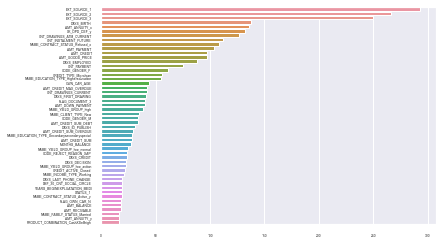

In [17]:
feats = get_important_features(classifier, 50)
default = [test_pred[i][1] for i in range(len(test_pred))]
sub_ID = list(test_data['SK_ID_CURR'])
submission = pd.DataFrame(sub_ID, columns = ['SK_ID_CURR'])
submission['TARGET'] = list(default)
submission.head()

In [18]:
submission.to_csv('all_table_submission.csv')

** Extracting Important Features **

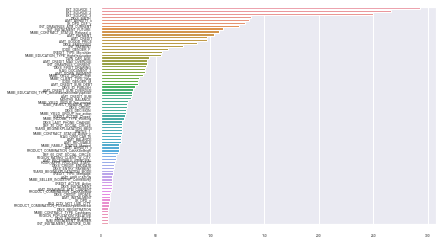

In [19]:
feats = get_important_features(classifier, 75)
feats = [feats[i][0] for i in range(len(feats))]

In [20]:
x_train = X_train[feats]
x_test = X_test[feats]

**Train on Linear Discriminant Analysis Model **

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [22]:
clf = LinearDiscriminantAnalysis()
clf.fit_transform(x_train, y_train)
lda_pred = clf.predict_proba(x_test)

In [23]:
default = [lda_pred[i][1] for i in range(len(lda_pred))]
sub_ID = list(test_data['SK_ID_CURR'])
lda_submission = pd.DataFrame(sub_ID, columns = ['SK_ID_CURR'])
lda_submission['TARGET'] = list(default)
lda_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.036377
1,100005,0.164069
2,100013,0.028768
3,100028,0.025484
4,100038,0.139633


In [24]:
lda_submission.to_csv('lda_submission.csv')